<a href="https://colab.research.google.com/github/NikBaybal/parser/blob/main/%D0%9F%D0%B0%D1%80%D1%81%D0%B5%D1%80_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85_%D0%BD%D0%B5%D0%B4%D0%B2%D0%B8%D0%B6%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [158]:
pip install openpyxl

In [159]:
pip install xlsxwriter

In [160]:
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime

url = 'https://doska.ykt.ru/nedvizhimost/kvartiry/prodau'
params = {'page': 1}
pages = 1
n = 1
df=pd.DataFrame(columns=['Desc','Price', 'Date','Link'])
while params['page'] <= pages:
    response = requests.get(url, params=params)
    soup = BeautifulSoup(response.text, 'lxml')
    items = soup.find_all('div', class_='d-post_body')

    for n, i in enumerate(items, start=n):
        itemDesc = i.find('div', class_='d-post_desc').text.strip()
        itemPrice = i.find('div', class_='d-post_price').text.strip().split("р")[0]
        itemDate = i.find('span', class_='d-post_date').text.strip()
        itemLink = i.find('a', class_='d-post_link').get('href')
        df = pd.concat([pd.DataFrame([[itemDesc, itemPrice, itemDate,itemLink]], columns=df.columns), df], ignore_index=True)
    last_page_num = 50
    #last_page_num = int(1)
    pages = last_page_num if pages < last_page_num else pages
    params['page'] += 1


In [161]:
flat_type=['112 серия',
            'Блочный',
            'Дерев. б/у',
            'Дерев. ч/б',
            'Другое',
            'Инд. планировка',
            'Каркасно-щитовой',
            'КПД',
            'Малосемейка',
            'Монолитно-каркасный',
            'Сталинка',
            'Хрущевка']

In [162]:
district=[
 '103 квартал (Ростелеком)',
 '11 квартал',
 '16 квартал',
 '17 квартал',
 '202 мкрн.',
 '203 мкрн.',
 '26 школа',
 '31 школа',
'Авиагруппа',
'Авиапорт',
'Автовокзал',
'Автодорожная',
'Авторынок',
'Апельсин',
'Белое Озеро',
'Борисовка-2',
'Вавилон',
'Вилюйский тракт',
'Гимеин',
'Глазная больница',
'ГРЭС',
'Даркылах',
'Дом быта',
'Другие пригороды',
'Другие районы',
'ДСК',
'ДСР',
'Жатай',
'Залог',
'Ильинка',
'Кангалассы',
'Кинотеатр Лена',
'Кирзавод',
'Крестьянский рынок',
'Крытый рынок',
'Маган',
'Маганский тракт',
'Манчаары',
'Марха',
'Муус Хайа',
'Намский тракт',
'Намцырский тракт',
'Областная больница',
'Площадь Победы',
'Покровский тракт',
'Поликлиника 1',
'Поселок Газовиков',
'Поселок Геологов',
'Пригородный',
'Прометей',
'Птицефабрика',
'Рабочий городок',
'Радиоцентр',
'Рынок Столичный',
'Сайсары',
'Сахацирк',
'Сергеляхское шоссе',
'Старый город',
'Студгородок',
'Табага',
'Тулагино-Кильдямцы',
'ТЦ "Олонхо"',
'Улус',
'Хатассы',
'Центр - район пл. Дружбы',
'Центр - район пл. Комсомольская',
'Центр - район пл. Ленина',
'Центр - район пл. Орджоникидзе',
'ЯГИТИ',
'ЯГСХА',
'ЯКСМК',
'ЯТЭК']

In [163]:
df_save=df.copy()

In [164]:
#df=df_save.copy() #использовать при перезапуске предобработки данных

In [165]:
df['Price']=df['Price'].str.replace('\xa0', '').astype('int')
df['Rooms'] = df['Desc'].apply(lambda x: int(x.split(" комн.")[0][-2:]) if 'комн.' in x else (0 if 'Студия' in x else -1))
df['Desc']=df['Desc'].str.split(", ")
df['Dist']=df['Desc'].apply(lambda x: "".join(filter(lambda x: x in district, x)))
df['Type']=df['Desc'].apply(lambda x: "".join(filter(lambda x: x in flat_type, x)))
df['Area']=df['Desc'].apply(lambda x: "".join(filter(lambda x: 'м²' in x, x)) if list(filter(lambda x: 'м²' in x, x))!=[] else -1)
df['Area']=df['Area'].str.replace(' м²', '').fillna(-1).astype('int')
df['Price_per_area']=(df['Price']/df['Area']/1000).round(3)

In [166]:
df.loc[df['Area']==-1,['Area','Price_per_area']]=None
df.drop(df.loc[df['Area'] >300].index, inplace=True)
df.drop(df.loc[df['Area'] <5].index, inplace=True)
df.drop(df.loc[df['Price']>35*1000000].index, inplace=True)
df.drop(df.loc[df['Price']<125000].index, inplace=True)
df.drop(df.loc[df['Price'].isin([1111111,1234567])].index, inplace=True)
df['Link']='https://doska.ykt.ru'+df['Link']

In [167]:
def hist_stat(name,col,k):
    data=df[col]
    data.plot(
        bins=k,
        title='Распределение '+ name,
        kind='hist',
        grid=True,
        figsize=(9, 4),
        legend=""
        #xlim=(0,lim)
        )
    print('Cтатистические показатели :')
    print(data.agg(['count','mean','median','min','max',np.var,np.std]))

Cтатистические показатели :
count     1875.000000
mean        54.383467
median      50.000000
min          5.000000
max        280.000000
var        586.283505
std         24.213292
Name: Area, dtype: float64


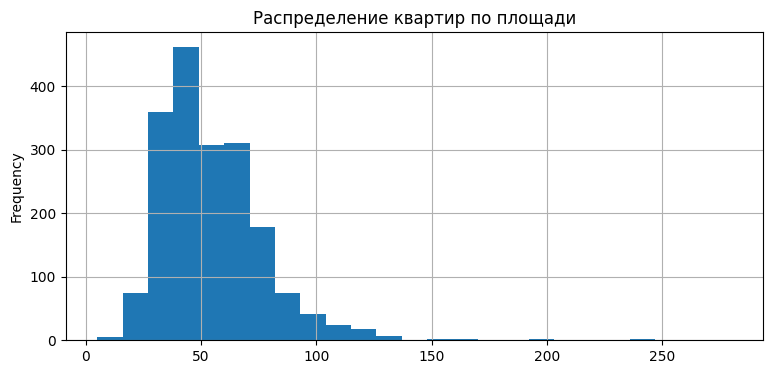

In [168]:
hist_stat('квартир по площади','Area',25)

Cтатистические показатели :
count     2.386000e+03
mean      6.742830e+06
median    6.300000e+06
min       1.950000e+05
max       3.000000e+07
var       9.015982e+12
std       3.002662e+06
Name: Price, dtype: float64


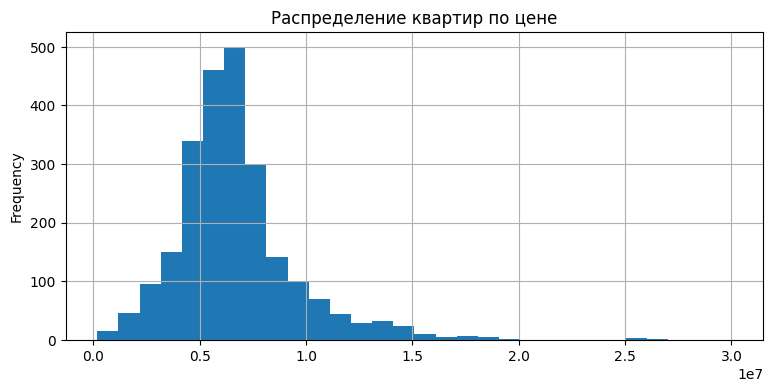

In [169]:
hist_stat('квартир по цене','Price',30)

In [170]:
df.describe()

,Price,Rooms,Area,Price_per_area
count,2.386000e+03,2386.000000,1875.000000,1875.000000
mean,6.742830e+06,1.849958,54.383467,129.362642
std,3.002662e+06,1.007370,24.213292,35.828254
min,1.950000e+05,-1.000000,5.000000,8.125000
25%,5.000000e+06,1.000000,38.000000,107.909500
50%,6.300000e+06,2.000000,50.000000,129.808000
75%,7.800000e+06,3.000000,64.500000,151.755000
max,3.000000e+07,4.000000,280.000000,350.000000


In [171]:
df.loc[df['Price_per_area']>300]

,Desc,Price,Date,Link,Rooms,Dist,Type,Area,Price_per_area
1172,"[Студия, 22 м², Инд. планировка, Другие районы]",7700000,"вчера, 08:10",https://doska.ykt.ru/14932174,0,Другие районы,Инд. планировка,22.0,350.000
1207,"[1 комн., 32 м², Инд. планировка, Другие районы]",10650000,"сегодня, 07:07",https://doska.ykt.ru/14970161,1,Другие районы,Инд. планировка,32.0,332.812


Cтатистические показатели :
count     1875.000000
mean       129.362642
median     129.808000
min          8.125000
max        350.000000
var       1283.663792
std         35.828254
Name: Price_per_area, dtype: float64


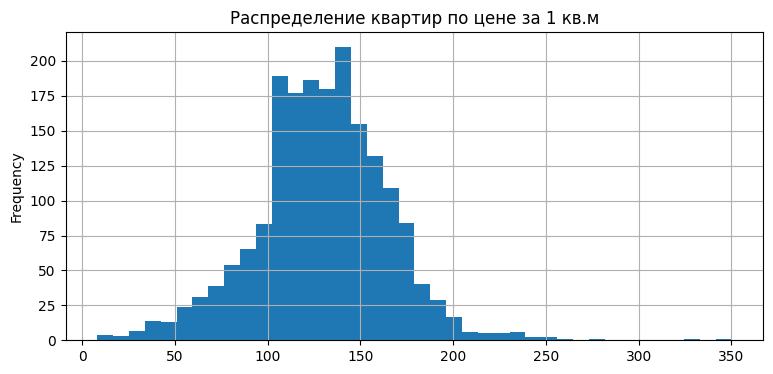

In [172]:
hist_stat('квартир по цене за 1 кв.м','Price_per_area',40)

In [173]:
with pd.ExcelWriter(f'{datetime.date.today()}.xlsx', engine='xlsxwriter') as writer:
  df.to_excel(writer, sheet_name='Sheet')

<Axes: title={'center': 'Кол-во продаваемых квартир по районам'}, xlabel='Район', ylabel='Кол-во'>

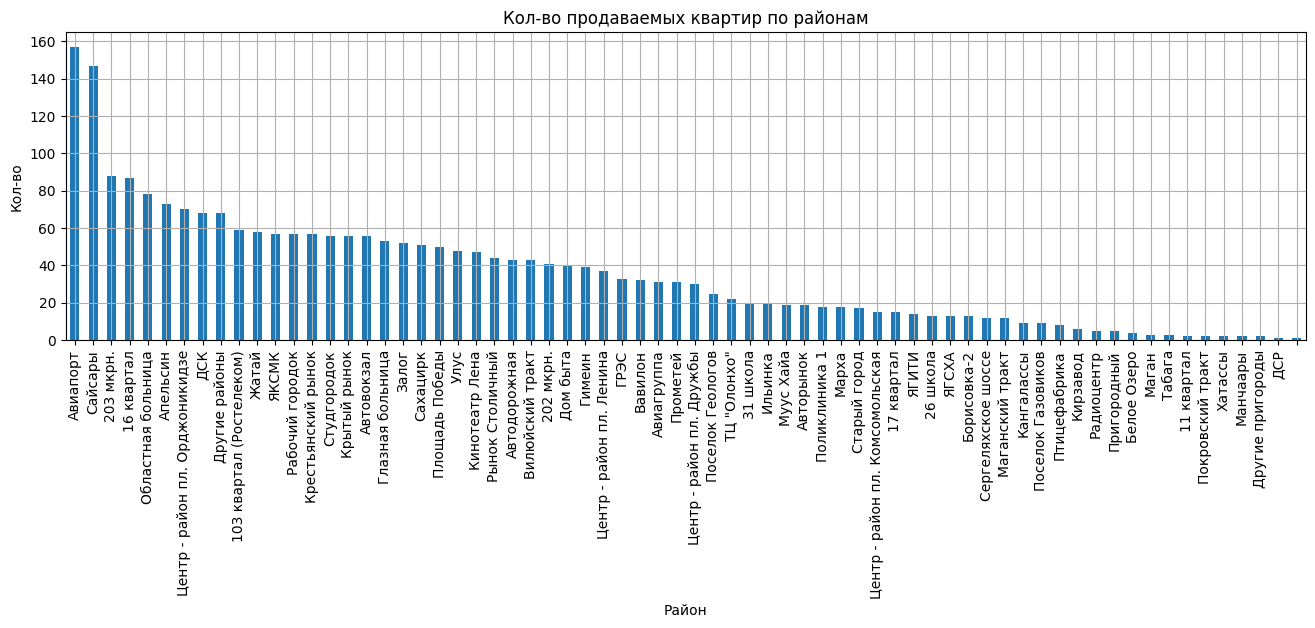

In [175]:
df.groupby('Dist')['Type'].count().sort_values(ascending=False).plot(
    xlabel='Район',
    ylabel='Кол-во',
    title='Кол-во продаваемых квартир по районам',
    kind='bar',
    grid=True,
    figsize=(16, 4),
    legend=""
    )

<Axes: title={'center': 'Средняя цена за 1 кв.м продаваемых квартир по районам'}, xlabel='Район', ylabel='Цена'>

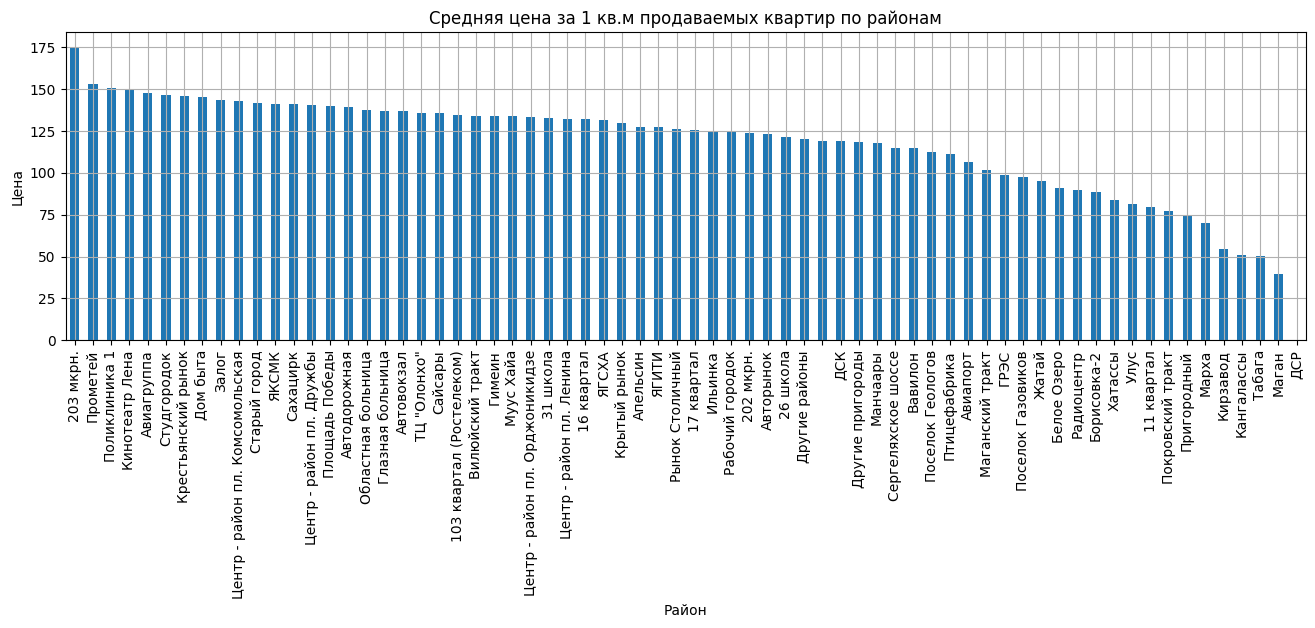

In [176]:
df.groupby('Dist')['Price_per_area'].mean().sort_values(ascending=False).plot(
    xlabel='Район',
    ylabel='Цена',
    title='Средняя цена за 1 кв.м продаваемых квартир по районам',
    kind='bar',
    grid=True,
    figsize=(16, 4),
    legend=""
    )

<Axes: title={'center': 'Средняя цена продаваемых квартир по районам'}, xlabel='Район', ylabel='Кол-во'>

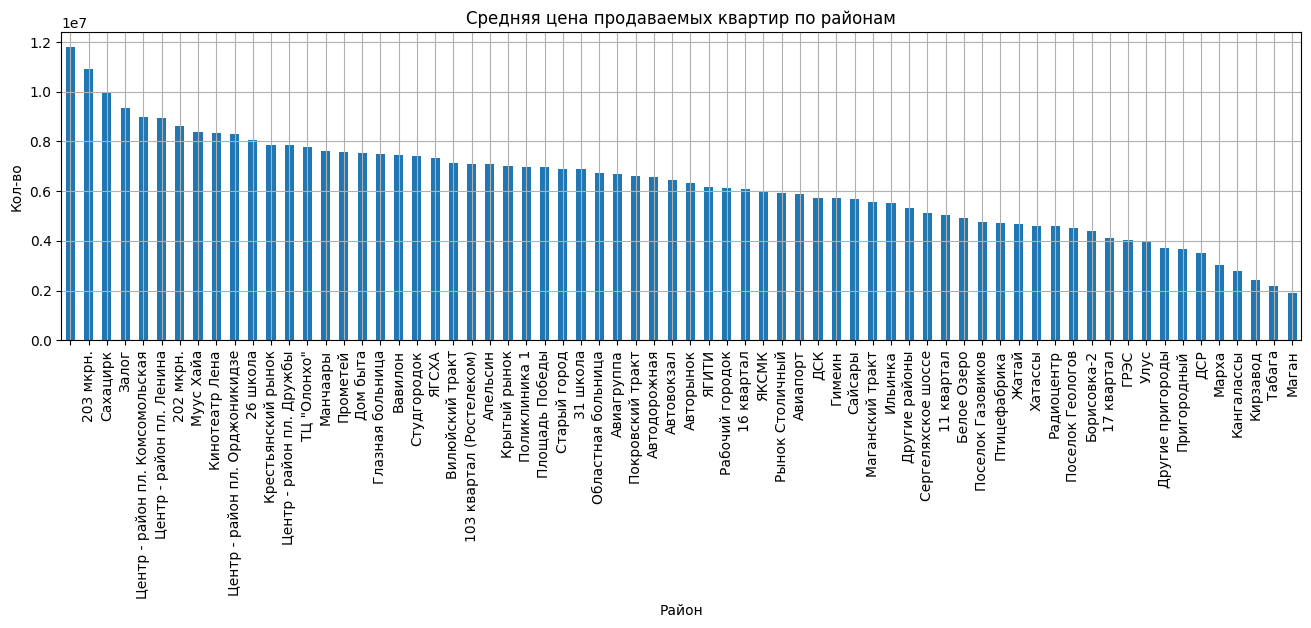

In [177]:
df.groupby('Dist')['Price'].mean().sort_values(ascending=False).plot(
    xlabel='Район',
    ylabel='Кол-во',
    title='Средняя цена продаваемых квартир по районам',
    kind='bar',
    grid=True,
    figsize=(16, 4),
    legend=""
    )

<Axes: title={'center': 'Кол-во продаваемых квартир по типам'}, xlabel='Район', ylabel='Кол-во'>

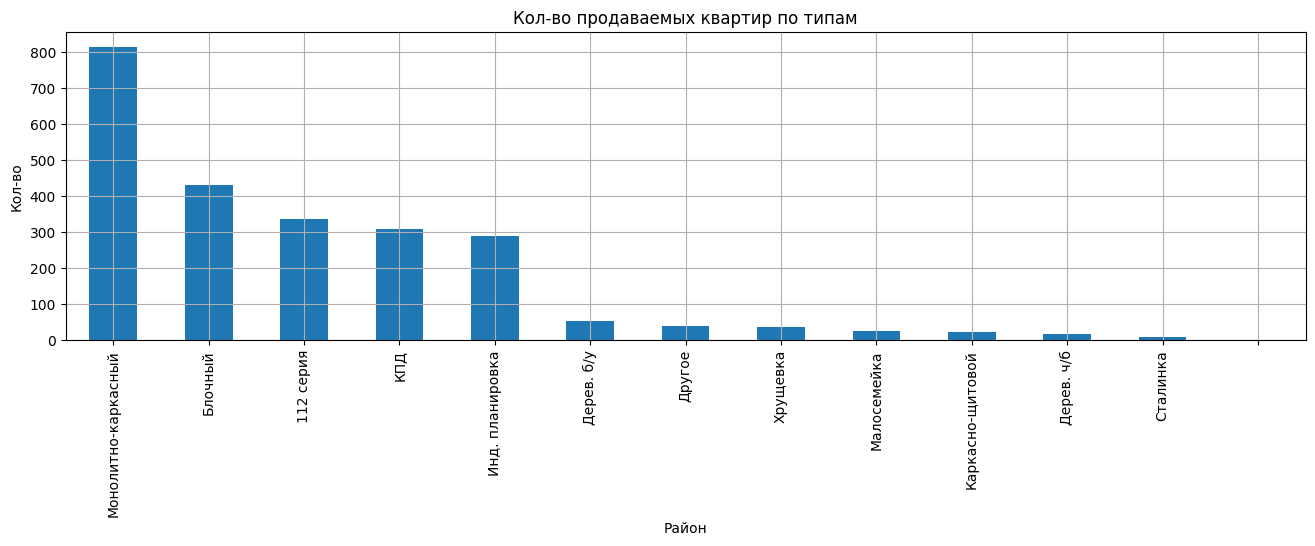

In [178]:
df.groupby('Type')['Dist'].count().sort_values(ascending=False).plot(
    xlabel='Район',
    ylabel='Кол-во',
    title='Кол-во продаваемых квартир по типам',
    kind='bar',
    grid=True,
    figsize=(16, 4),
    legend=""
    )

In [179]:
top_type=['112 серия',
            'Блочный',
            'Инд. планировка',
            'КПД',
            'Монолитно-каркасный']

In [180]:
top_dist=[
'Студгородок',
'Крытый рынок',
'Крестьянский рынок',
'Кинотеатр Лена',
'Залог',
'Глазная больница',
'Вавилон',
'31 школа',
'26 школа',
'Автовокзал',
'202 мкрн.',
'203 мкрн.',
'103 квартал (Ростелеком)',
'Апельсин',
'Дом быта',
'Муус Хайа',
'Площадь Победы',
'Поликлиника 1',
'Старый город',
'Сахацирк',
'Центр - район пл. Дружбы',
'Центр - район пл. Комсомольская',
'Центр - район пл. Ленина',
'Центр - район пл. Орджоникидзе',
'ТЦ "Олонхо"']

<Axes: title={'center': 'Средняя цена популярных типов квартир по районам'}, xlabel='Район', ylabel='Цена'>

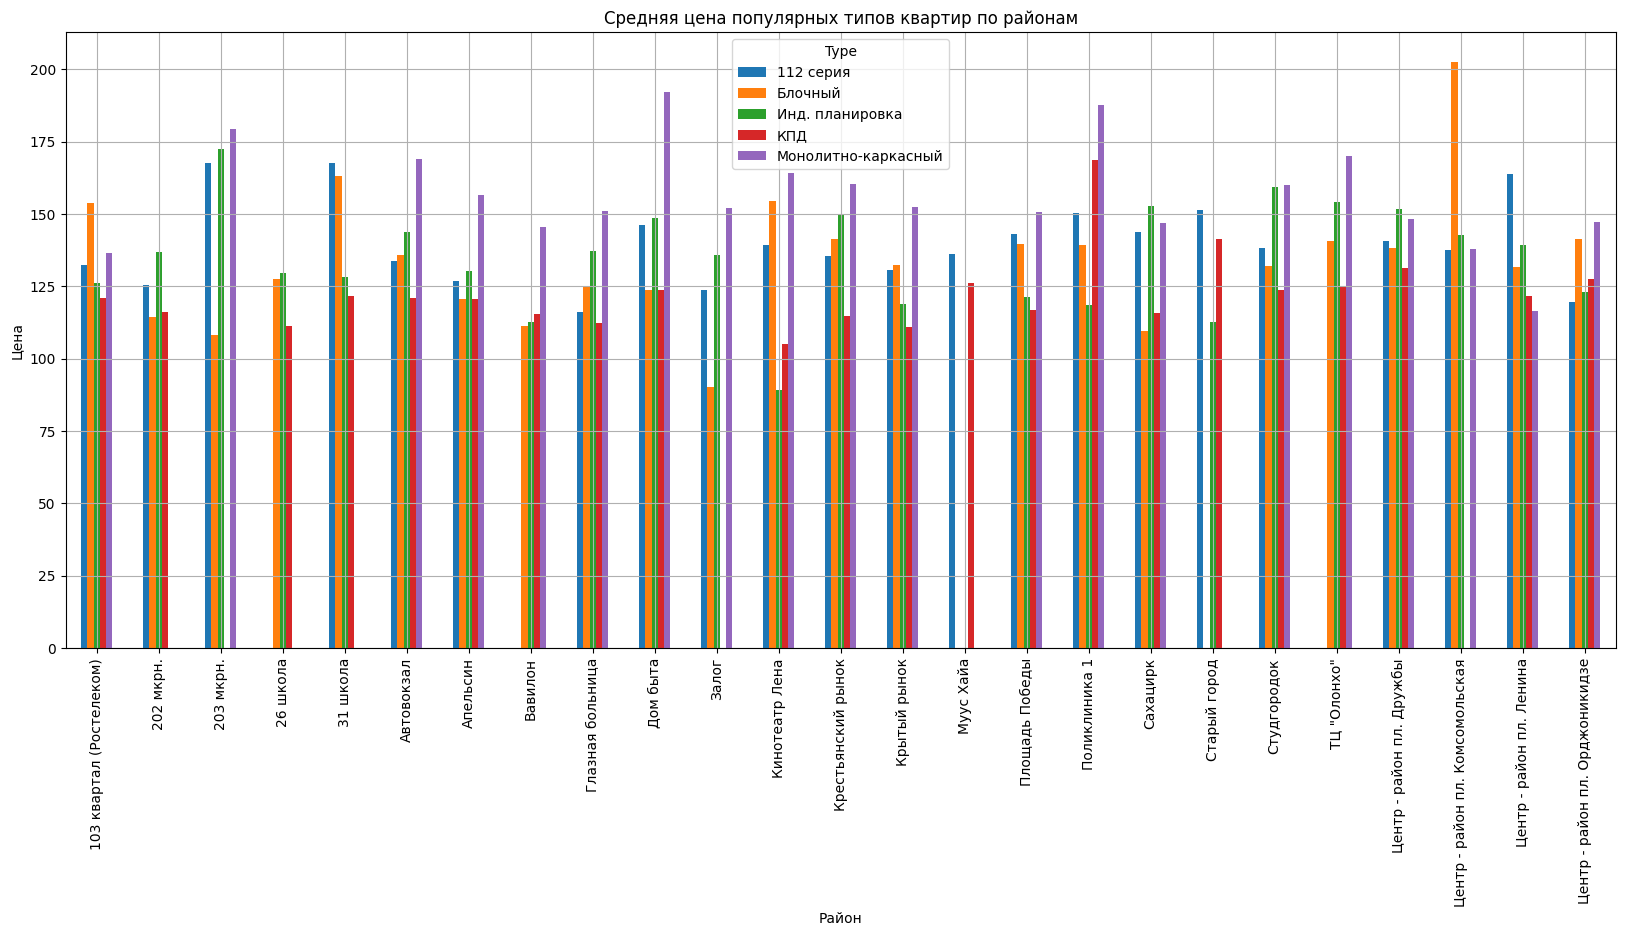

In [181]:
df.loc[(df['Dist'].isin(top_dist)) &(df['Type'].isin(top_type))].pivot_table(
    index=['Dist'],columns='Type',values='Price_per_area', aggfunc='mean').plot(
    xlabel='Район',
    ylabel='Цена',
    title='Средняя цена популярных типов квартир по районам',
    kind='bar',
    grid=True,
    figsize=(20, 8)
    )

<Axes: title={'center': 'Средняя цена за 1 кв.м. Монолитно-каркасных типов квартир по районам'}, xlabel='Район', ylabel='Цена'>

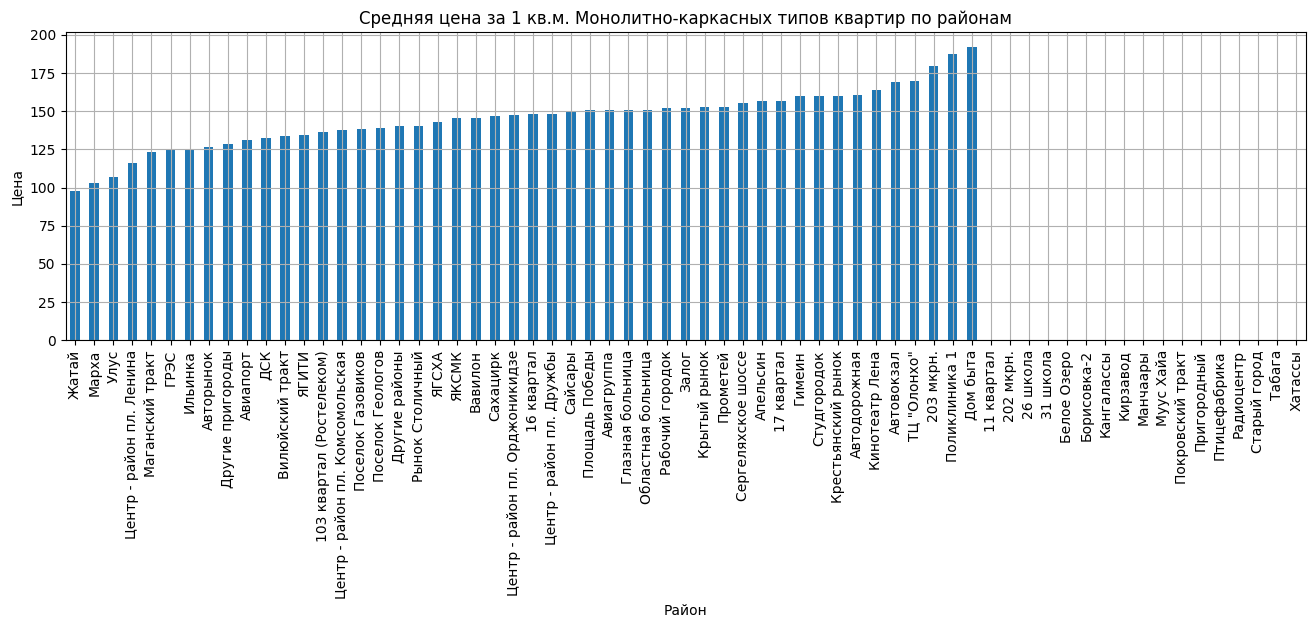

In [182]:
df.loc[df['Type'].isin(top_type)].pivot_table(
    index=['Dist'],columns='Type',values='Price_per_area', aggfunc='mean')['Монолитно-каркасный'].sort_values(ascending=True).plot(
    xlabel='Район',
    ylabel='Цена',
    title='Средняя цена за 1 кв.м. Монолитно-каркасных типов квартир по районам',
    kind='bar',
    grid=True,
    figsize=(16, 4)
    )

<Axes: title={'center': 'Кол-во монолитно-каркасных типов квартир по районам'}, xlabel='Район', ylabel='Цена'>

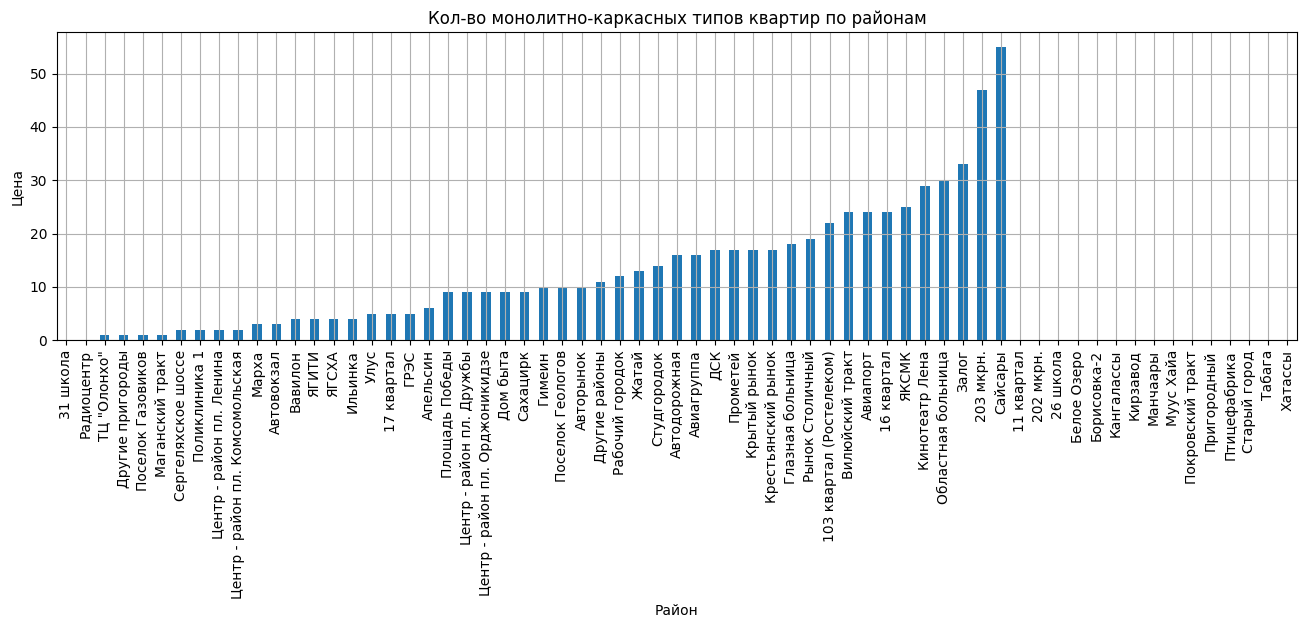

In [183]:
df.loc[df['Type'].isin(top_type)].pivot_table(
    index=['Dist'],columns='Type',values='Price_per_area', aggfunc='count')['Монолитно-каркасный'].sort_values().plot(
    xlabel='Район',
    ylabel='Цена',
    title='Кол-во монолитно-каркасных типов квартир по районам',
    kind='bar',
    grid=True,
    figsize=(16, 4)
    )

In [184]:
df.loc[(df['Type']==('Монолитно-каркасный'))&(df['Dist'].isin(top_dist)&(df['Price']<7000000))].sort_values(by='Price_per_area').tail(10)

,Desc,Price,Date,Link,Rooms,Dist,Type,Area,Price_per_area
1500,"[1 комн., Монолитно-каркасный, Площадь Победы]",6200000,"21 июл, 15:58",https://doska.ykt.ru/14923247,1,Площадь Победы,Монолитно-каркасный,NaN,NaN
1573,"[Студия, Монолитно-каркасный, Глазная больница]",5000000,"24 июл, 16:58",https://doska.ykt.ru/14815308,0,Глазная больница,Монолитно-каркасный,NaN,NaN
1601,"[1 комн., Монолитно-каркасный, Глазная больница]",4600000,"25 июл, 21:03",https://doska.ykt.ru/14548887,1,Глазная больница,Монолитно-каркасный,NaN,NaN
1808,"[1 комн., Монолитно-каркасный, Залог]",5800000,"2 авг, 12:24",https://doska.ykt.ru/14945637,1,Залог,Монолитно-каркасный,NaN,NaN
1817,"[1 комн., Монолитно-каркасный, Студгородок]",5200000,"2 авг, 14:01",https://doska.ykt.ru/14945874,1,Студгородок,Монолитно-каркасный,NaN,NaN
2016,"[1 комн., Монолитно-каркасный, 103 квартал (Ро...",6300000,"8 авг, 15:59",https://doska.ykt.ru/14957358,1,103 квартал (Ростелеком),Монолитно-каркасный,NaN,NaN
2103,"[1 комн., Монолитно-каркасный, Площадь Победы]",6600000,"10 авг, 22:21",https://doska.ykt.ru/14899820,1,Площадь Победы,Монолитно-каркасный,NaN,NaN
2131,"[1 комн., Монолитно-каркасный, Площадь Победы]",6200000,"12 авг, 10:59",https://doska.ykt.ru/14964660,1,Площадь Победы,Монолитно-каркасный,NaN,NaN
2152,"[1 комн., Монолитно-каркасный, Залог]",6500000,"13 авг, 15:12",https://doska.ykt.ru/14967163,1,Залог,Монолитно-каркасный,NaN,NaN
2288,"[1 комн., Монолитно-каркасный, Крытый рынок]",5900000,"17 авг, 13:55",https://doska.ykt.ru/14975662,1,Крытый рынок,Монолитно-каркасный,NaN,NaN


<Axes: title={'center': 'Средняя цена за 1 кв.м. Монолитно-каркасных типов квартир по районам'}, xlabel='Район', ylabel='Цена'>

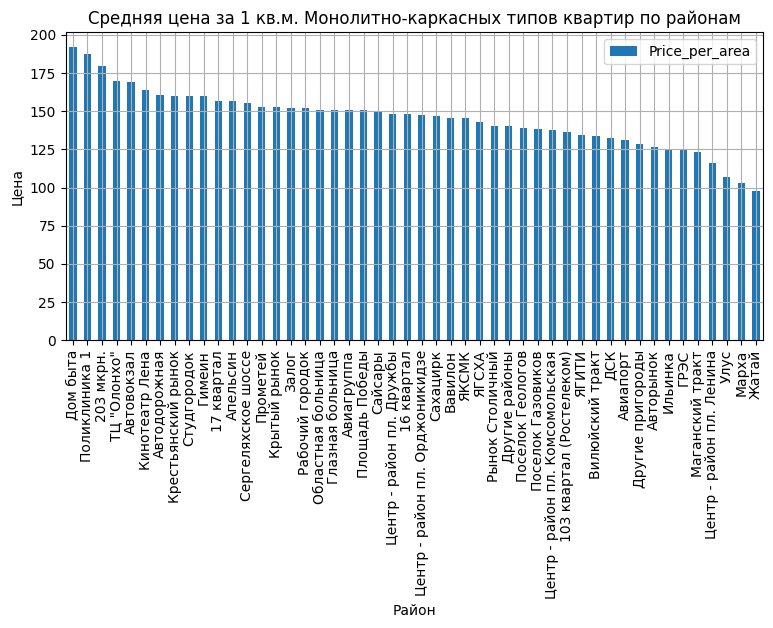

In [185]:
df.loc[df['Type']==('Монолитно-каркасный')].pivot_table(
    index=['Dist'],values='Price_per_area', aggfunc='mean').sort_values(by=['Price_per_area'], ascending=False).plot(
    xlabel='Район',
    ylabel='Цена',
    title='Средняя цена за 1 кв.м. Монолитно-каркасных типов квартир по районам',
    kind='bar',
    grid=True,
    figsize=(9, 4)
    )